In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap, ops
import numpy as np
import jax
from jax.scipy.linalg import expm
import eigAD
from jax.config import config   
config.update("jax_enable_x64", True)

In [3]:
# tunning parameter (constant in grad)
numStates=25
numSteps=31
numBands=2
fr=25.18
kpoints=250
kvec=jnp.linspace(-1,0,kpoints)

def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)


C = []
for i in range(2,numStates,2):
    C = C + [0,i]
C = np.array(C)
D = np.zeros(numStates)
M1 = tridiag(C,D,-1 * C)

E = [0]
for i in range(2,numStates,2):
    E = E + [(i)**2,(i)**2]
M2 = np.array(-np.diag(E))


F = np.concatenate((np.array([np.sqrt(2)]), np.ones(numStates-3)))
M3 = np.diag(F,-2) + np.diag(F,2)

2021-09-24 12:06:00.696427: W external/org_tensorflow/tensorflow/compiler/xla/service/platform_util.cc:205] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: Internal: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_INVALID_DEVICE: invalid device ordinal


In [4]:
freq = 70.0
Ttot = 1/freq
ftot = 1/Ttot
dT = Ttot/numSteps
N = 31

tVec = jnp.linspace(0,Ttot,N)
dT = tVec[1] - tVec[0]
tVec = tVec[:-1]
tVec = tVec + dT/2
modfunc = 1 + 0.5 * jnp.sin(2 * jnp.pi * freq * tVec)

In [5]:
# freqs: driving frequencies
# alphas: driving strength

M1 = jnp.asarray(M1,dtype=jnp.complex64)
M2 = jnp.asarray(M2,dtype=jnp.complex64)
M3 = jnp.asarray(M3,dtype=jnp.complex64)

def computeFloquet(modulation):
    
    A = modulation[0]
    modulation = modulation[1:]
    dTau = (2 * jnp.pi * fr) * dT

    @jax.jit
    def perKstep(k):
        unitaryInit = jnp.identity(M1.shape[0],dtype=jnp.complex64)

        @jax.jit
        def scanf(unitary,tIdx):
            dU = expm(-1j * dTau * createHmat(tIdx,k))
            dU = jnp.asarray(dU,dtype=jnp.complex64)
            unitary = jnp.asarray(unitary,dtype=jnp.complex64)
            unitary = jnp.matmul(unitary,dU)
            return unitary,0

        res, _ = jax.lax.scan(scanf,unitaryInit,jnp.arange(N))
        return res


    @jax.jit
    def createHmat(tIdx,k):
        newMat = (k**2) * jnp.identity(numStates,dtype=jnp.complex64) - 2* 1j * k * M1 -M2  - (1/4) * M3 * A * modulation[tIdx]
        return newMat
    

    def genUni():
        kMap = vmap(perKstep)
        return kMap(kvec)

    res = genUni()

    def eigWrapper(mat):
        return eigAD.eig(mat)

    eigWrapper= jax.jit(eigWrapper,backend='cpu')
    eigWrapper= vmap(eigWrapper)
    b,vF = eigWrapper(res)
    rawEfloquet = jnp.real(1j*jnp.log(b)* (ftot/fr) / (2*np.pi))
    
    @jax.jit
    def blochStates(i):
        k = kvec[i]
        currF = vF[i,:,:] 
        H0 =  (k**2) * jnp.identity(numStates) - 2* 1j * k * M1 -M2  - (1/4) * M3 * A 
        a,vS = jnp.linalg.eigh(H0)
        vS = jnp.transpose(vS)
        Cvec = jnp.matmul(vS,jnp.conjugate(currF))
        Pvec = jnp.multiply(Cvec,jnp.conjugate(Cvec))
        inds = jnp.argmax(jnp.real(Pvec),axis=1)
        Efloquet = rawEfloquet[i,inds[:numBands]]
        return Efloquet
    bandsF = vmap(blochStates)(jnp.arange(250))

    return bandsF
    
    


In [12]:
init_para = np.ones(N)
init_para[0] = 2.0
init_para[1:] = modfunc


#bandsF = computeFloquet(jnp.array(init_para))

@jax.jit
def loss(params):
    params = jnp.array(params)
    bandsF = computeFloquet(params)
    bandsF = jnp.sort(bandsF,axis=1)
    gaps = bandsF[:,1] - bandsF[:,0]
    minGap = jnp.min(gaps)
    return jnp.abs(minGap - 0.5)

loss= jax.jit(loss,backend='cpu')

In [13]:
grad(loss)(init_para)

DeviceArray([-0.0857636 , -0.00733626, -0.0123534 , -0.01646438,
             -0.01964758, -0.02197378, -0.02353851, -0.02439603,
             -0.02454019, -0.02393533, -0.02255794, -0.02041025,
             -0.01750356, -0.01383856, -0.0094097 , -0.00424105,
              0.00156269,  0.00778181,  0.01408809,  0.02008929,
              0.02538619,  0.02961867,  0.03249539,  0.03381372,
              0.03347496,  0.03149426,  0.02800211,  0.02323532,
              0.01751619,  0.01122029,  0.00473874], dtype=float64)

In [15]:
res = init_para
def callback(xk):
    global res
    res = np.vstack((res,xk))
    np.save("callbacks.npy",res)

import scipy.optimize

def value_and_grad_numpy(f):
    def val_grad_f(*args):
        value, grad = jax.value_and_grad(f)(*args)
        return np.array(value), np.array(grad)
    return val_grad_f
results = scipy.optimize.minimize(value_and_grad_numpy(loss), np.array(init_para),
                                  method='L-BFGS-B', jac=True,callback=callback)
print("success:", results.success, "\nniterations:", results.nit, "\nfinal loss:", results.fun)


KeyboardInterrupt: 

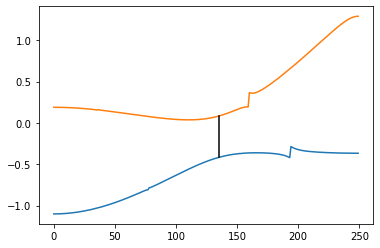

In [22]:

import matplotlib.pyplot as plt
bandsF = computeFloquet(jnp.array(results.x))
bandsF = jnp.sort(bandsF,axis=1)
gaps = bandsF[:,1] - bandsF[:,0]
xpoint = jnp.argmin(gaps)
plt.plot(bandsF[:,:3])
plt.plot((xpoint,xpoint),(bandsF[xpoint,1] , bandsF[xpoint,0]),'k-')

In [25]:
jnp.min(gaps)

DeviceArray(0.5, dtype=float32)

In [24]:
alpha = 0.1
para = init_para
checkpoints = []
for i in range(80):
    para -= alpha * grad(computeFloquetLoss)(para)
    res = computeFloquetLoss(para)
    checkpoints += [(para,res)]
    print("run " + str(i) + "  , loss is" + str(res))

run 0  , loss is0.24477497
run 1  , loss is0.24446136
run 2  , loss is0.2441501
run 3  , loss is0.24383914
run 4  , loss is0.24352923
run 5  , loss is0.24322133
run 6  , loss is0.24287999
run 7  , loss is0.24257249
run 8  , loss is0.24226208
run 9  , loss is0.24194947
run 10  , loss is0.24210955
run 11  , loss is0.2417938
run 12  , loss is0.24147695
run 13  , loss is0.2411706
run 14  , loss is0.2408526
run 15  , loss is0.24053527
run 16  , loss is0.24021888
run 17  , loss is0.239966
run 18  , loss is0.2396539
run 19  , loss is0.23930791
run 20  , loss is0.2389987
run 21  , loss is0.2386868
run 22  , loss is0.23837298
run 23  , loss is0.23805785
run 24  , loss is0.23774199
run 25  , loss is0.2374257
run 26  , loss is0.23759182
run 27  , loss is0.23727451
run 28  , loss is0.23695745
run 29  , loss is0.23664108
run 30  , loss is0.23632602
run 31  , loss is0.23601316
run 32  , loss is0.235662
run 33  , loss is0.23535216
run 34  , loss is0.23503946
run 35  , loss is0.23472251


KeyboardInterrupt: 

Text(0, 0.5, 'loss')

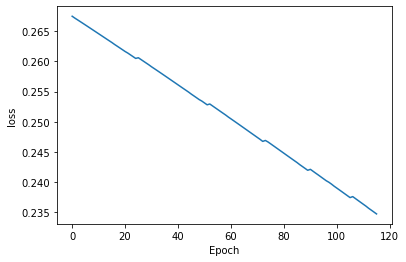

In [25]:
loss = [checkpoints[i][1] for i in range(len(checkpoints))]
import matplotlib.pyplot as plt
plt.plot(loss)
plt.xlabel("Epoch")
plt.ylabel("loss")

In [26]:
from scipy.optimize import Bounds
lowerBound = [1] + [0 for i in range(N-1)]
upperBound = [10] + [2 for i in range(N-1)]
bounds = Bounds(lowerBound,upperBound)


In [27]:
len(lowerBound)

31

In [ ]:
np.save("/data/hpan/trivial.npy",results)